In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import plots2
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
%matplotlib inline

## Using some instruments from Freesound challenge

In [2]:
df = pd.read_csv('instruments.csv')

In [3]:
df.head()

fname      label
0  5388d14d.wav  Saxophone
1  c685f05f.wav  Saxophone
2  36d20ab5.wav  Saxophone
3  d6665734.wav  Saxophone
4  7352e28f.wav  Saxophone

In [4]:
df.label.value_counts()

Saxophone           30
Violin_or_fiddle    30
Hi-hat              30
Snare_drum          30
Acoustic_guitar     30
Double_bass         30
Cello               30
Bass_drum           30
Flute               30
Clarinet            30
Name: label, dtype: int64

In [5]:
df = df.set_index('fname')

In [6]:
df.head()

label
fname                  
5388d14d.wav  Saxophone
c685f05f.wav  Saxophone
36d20ab5.wav  Saxophone
d6665734.wav  Saxophone
7352e28f.wav  Saxophone

### add some time information 

In [7]:
for f in df.index:
    rate,signal = wavfile.read('wavfiles\\' + f)
    df.at[f,'length'] = signal.shape[0]/rate

In [8]:
df.head()

label  length
fname                          
5388d14d.wav  Saxophone    4.14
c685f05f.wav  Saxophone    1.54
36d20ab5.wav  Saxophone    4.90
d6665734.wav  Saxophone   10.50
7352e28f.wav  Saxophone    6.24

In [9]:
classes = list(set(df.label.values))
classes

['Flute',
 'Double_bass',
 'Cello',
 'Bass_drum',
 'Saxophone',
 'Acoustic_guitar',
 'Snare_drum',
 'Hi-hat',
 'Violin_or_fiddle',
 'Clarinet']

In [10]:
#group by audio length
class_dist = df.groupby('label')['length'].mean()

In [11]:
class_dist.sort_values(ascending=False)

label
Flute               8.054667
Saxophone           7.124000
Acoustic_guitar     6.948667
Clarinet            6.596000
Cello               5.000667
Violin_or_fiddle    4.530000
Snare_drum          3.987333
Hi-hat              3.357333
Double_bass         3.206000
Bass_drum           1.937333
Name: length, dtype: float64

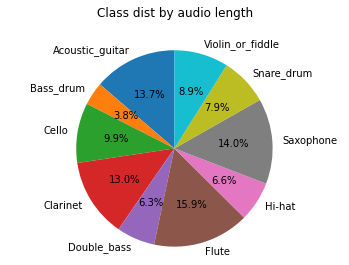

In [12]:
fig,ax = plt.subplots()
ax.set_title('Class dist by audio length',y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()

In [13]:
df.index

Index(['5388d14d.wav', 'c685f05f.wav', '36d20ab5.wav', 'd6665734.wav',
       '7352e28f.wav', '8fa096bf.wav', '2f9c5f62.wav', '9cd05a2b.wav',
       'ab465bf9.wav', 'c40632d7.wav',
       ...
       'e43f7db2.wav', '3c66098d.wav', 'ad42e493.wav', '740e5bb7.wav',
       '800b401e.wav', '3c713bcf.wav', '2fc00271.wav', 'b0c06255.wav',
       '71c6451f.wav', '5de123c3.wav'],
      dtype='object', name='fname', length=300)

In [14]:
df.reset_index(inplace=True)

In [15]:
df.index

RangeIndex(start=0, stop=300, step=1)

In [16]:
def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [17]:
wav_path = 'wavfiles\\'

#make dictionaries for each of the instrument values
signals = {}; fft={}; fbank={}; mfccs={};

#1s/40 = 25ms (window size)
time_per_sec = 40;
nfft = int(44100/time_per_sec)+1

#get first entry for each class
for c in classes:
    wav_file = df[df.label==c].iloc[0,0]
    signal, rate = librosa.load(wav_path +wav_file,sr=44100 )
    signals[c] = signal
    fft[c] = calc_fft(signal,rate)
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=nfft).T     #1 sec of audio, 26 filters
    fbank[c] = bank
    mel = mfcc(signal[:rate],rate,numcep = 13, nfilt=26,nfft=nfft).T   #keep 13 cepstrals after dct
    mfccs[c] = mel

In [18]:
signals.keys()
for k,v in signals.items():
    print(len(v))

224028
276066
201096
107604
182574
441000
263718
138474
130536
295470


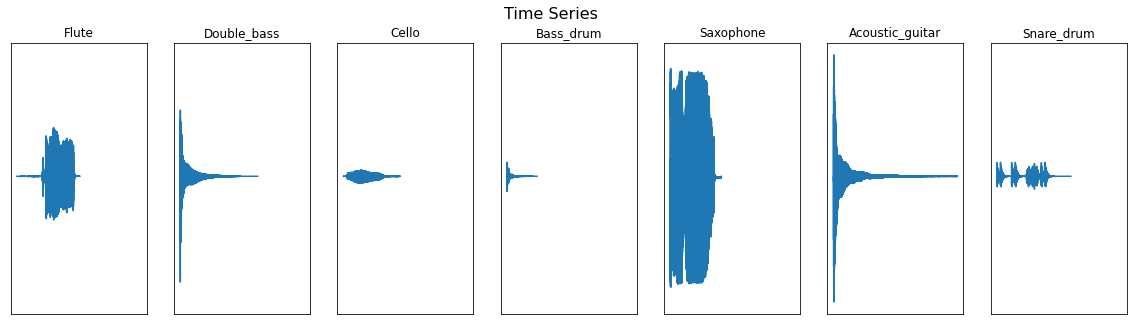

In [23]:
plots2.plot_signals(signals)
plt.show()

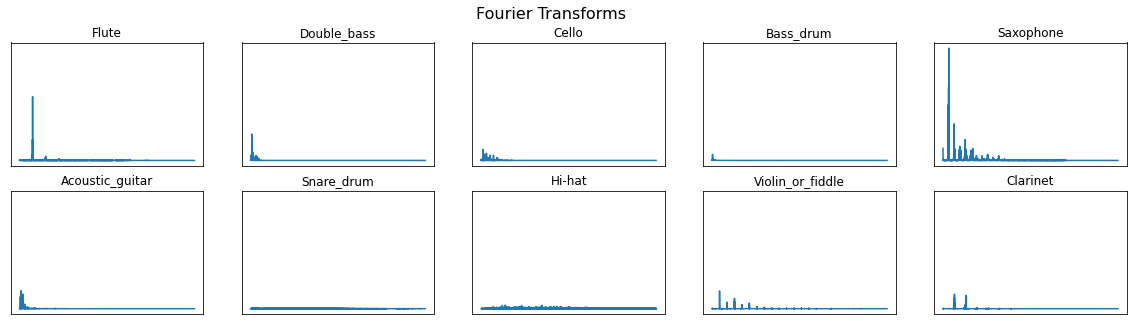

In [24]:
plots2.plot_fft(fft)
plt.show()

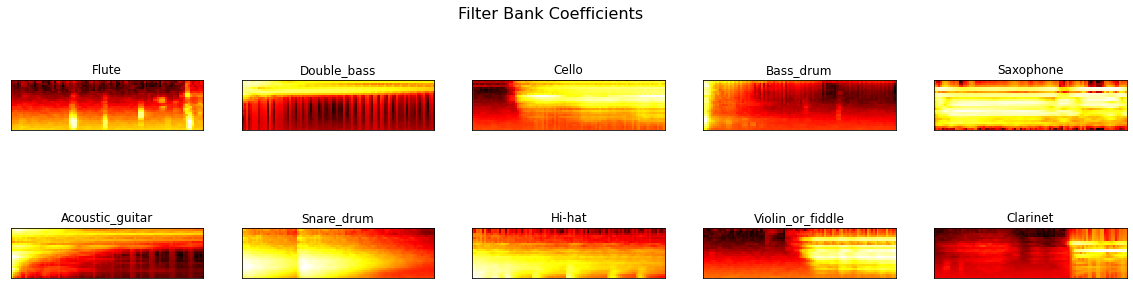

In [25]:
plots2.plot_fbank(fbank)
plt.show()

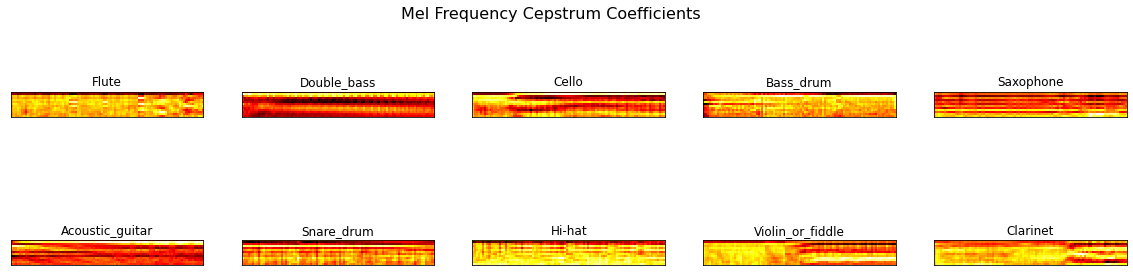

In [26]:
plots2.plot_mfccs(mfccs)
plt.show()

### remove signal below threshold

In [27]:
def envelope(y, rate, threshold):
    mask = []
    y=pd.Series(y).apply(np.abs)
    #plt.plot(y)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    #plt.plot(y_mean)
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [28]:
#get first entry for each class
for c in classes:
    wav_file = df[df.label==c].iloc[0,0]
    signal, rate = librosa.load(wav_path +wav_file,sr=44100 )
    mask = envelope(signal,rate,0.0005)
    signal = signal[mask]
    #break;
    signals[c] = signal
    fft[c] = calc_fft(signal,rate)
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=nfft).T
    fbank[c] = bank
    mel = mfcc(signal[:rate],rate,numcep = 13, nfilt=26,nfft=nfft).T
    mfccs[c] = mel

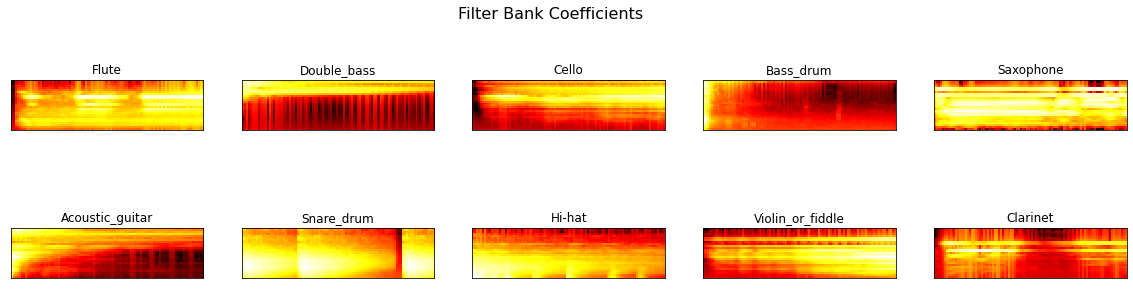

In [31]:
plots2.plot_fbank(fbank)
plt.show()

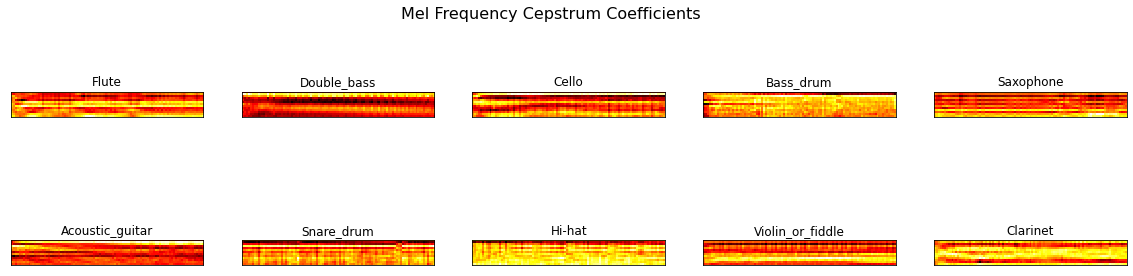

In [32]:
plots2.plot_mfccs(mfccs)
plt.show()

In [33]:
mfccs['Bass_drum'][0]

array([ -4.48974438,  -4.37213011,  -5.382107  ,  -6.67196169,
        -7.1440881 ,  -6.88688062,  -7.01811604,  -7.12526205,
        -7.17421324,  -7.19375011,  -7.3360359 ,  -7.28672661,
        -7.32380424,  -7.19947019,  -7.35432553,  -7.60098114,
        -7.89390653,  -8.05238555,  -8.17135046,  -8.18787975,
        -8.70362603,  -9.07720608,  -9.24842421,  -9.2949185 ,
        -9.72427925, -10.33371482, -10.245963  , -10.56197027,
       -11.12672371, -11.09687938, -10.84049032, -10.44756879,
       -10.43782421, -10.39014797, -10.3259269 , -10.20528056,
       -10.12927503,  -9.96898331,  -9.87509215,  -9.80164235,
        -9.76339289,  -9.92485328, -10.02041108, -10.16986527,
       -10.36409839, -10.57084394, -10.52050983, -10.61536165,
       -10.6816564 , -10.79720646, -10.92018994, -11.0664404 ,
       -11.14408708, -11.50195033, -11.53922755, -11.65732567,
       -11.9135591 , -11.94887201, -11.9964014 , -12.27590984,
       -12.52919076, -12.70611731, -12.92947873, -13.28

## clean the wav files 

In [36]:
clean_path = 'clean\\'

if len(os.listdir(clean_path)) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load(wav_path+f, sr=16000)
        mask = envelope(signal,rate,0.0005)
        wavfile.write(filename=clean_path+f,rate=rate,data=signal[mask])